<a href="https://colab.research.google.com/github/zsh2000/CS598-DL4H/blob/main/dift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### install requirements and import libraries

In [ ]:
!pip install diffusers==0.15.0
!pip install transformers==4.29.2
!pip install xformers==0.0.20
!pip install ipympl==0.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.5 MB/s eta 0:00:00


In [ ]:
%matplotlib widget
import os
import gc
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import PILToTensor
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from diffusers.models.unet_2d_condition import UNet2DConditionModel
from diffusers import DDIMScheduler
from diffusers import StableDiffusionPipeline

from google.colab import output
output.enable_custom_widget_manager()

### define DIST_sd

In [ ]:
class MyUNet2DConditionModel(UNet2DConditionModel):
    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        up_ft_indices,
        encoder_hidden_states: torch.Tensor,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None):
        r"""
        Args:
            sample (`torch.FloatTensor`): (batch, channel, height, width) noisy inputs tensor
            timestep (`torch.FloatTensor` or `float` or `int`): (batch) timesteps
            encoder_hidden_states (`torch.FloatTensor`): (batch, sequence_length, feature_dim) encoder hidden states
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttnProcessor` as defined under
                `self.processor` in
                [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).
        """
        # By default samples have to be AT least a multiple of the overall upsampling factor.
        # The overall upsampling factor is equal to 2 ** (# num of upsampling layears).
        # However, the upsampling interpolation output size can be forced to fit any upsampling size
        # on the fly if necessary.
        default_overall_up_factor = 2**self.num_upsamplers

        # upsample size should be forwarded when sample is not a multiple of `default_overall_up_factor`
        forward_upsample_size = False
        upsample_size = None

        if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
            # logger.info("Forward upsample size to force interpolation output size.")
            forward_upsample_size = True

        # prepare attention_mask
        if attention_mask is not None:
            attention_mask = (1 - attention_mask.to(sample.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)

        # timesteps does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=self.dtype)

        emb = self.time_embedding(t_emb, timestep_cond)

        if self.class_embedding is not None:
            if class_labels is None:
                raise ValueError("class_labels should be provided when num_class_embeds > 0")

            if self.config.class_embed_type == "timestep":
                class_labels = self.time_proj(class_labels)

            class_emb = self.class_embedding(class_labels).to(dtype=self.dtype)
            emb = emb + class_emb

        # 2. pre-process
        sample = self.conv_in(sample)

        # 3. down
        down_block_res_samples = (sample,)
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

            down_block_res_samples += res_samples

        # 4. mid
        if self.mid_block is not None:
            sample = self.mid_block(
                sample,
                emb,
                encoder_hidden_states=encoder_hidden_states,
                attention_mask=attention_mask,
                cross_attention_kwargs=cross_attention_kwargs,
            )

        # 5. up
        up_ft = {}
        for i, upsample_block in enumerate(self.up_blocks):

            if i > np.max(up_ft_indices):
                break

            is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            # if we have not reached the final block and need to forward the
            # upsample size, we do it here
            if not is_final_block and forward_upsample_size:
                upsample_size = down_block_res_samples[-1].shape[2:]

            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    upsample_size=upsample_size,
                    attention_mask=attention_mask,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample, temb=emb, res_hidden_states_tuple=res_samples, upsample_size=upsample_size
                )

            if i in up_ft_indices:
                up_ft[i] = sample.detach()

        output = {}
        output['up_ft'] = up_ft
        return output

class OneStepSDPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        img_tensor,
        t,
        up_ft_indices,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None
    ):

        device = self._execution_device
        latents = self.vae.encode(img_tensor).latent_dist.sample() * self.vae.config.scaling_factor
        t = torch.tensor(t, dtype=torch.long, device=device)
        noise = torch.randn_like(latents).to(device)
        latents_noisy = self.scheduler.add_noise(latents, noise, t)
        unet_output = self.unet(latents_noisy,
                               t,
                               up_ft_indices,
                               encoder_hidden_states=prompt_embeds,
                               cross_attention_kwargs=cross_attention_kwargs)
        return unet_output


class SDFeaturizer:
    def __init__(self, sd_id='stabilityai/stable-diffusion-2-1'):
        unet = MyUNet2DConditionModel.from_pretrained(sd_id, subfolder="unet")
        onestep_pipe = OneStepSDPipeline.from_pretrained(sd_id, unet=unet, safety_checker=None)
        onestep_pipe.vae.decoder = None
        onestep_pipe.scheduler = DDIMScheduler.from_pretrained(sd_id, subfolder="scheduler")
        gc.collect()
        onestep_pipe = onestep_pipe.to("cuda")
        onestep_pipe.enable_attention_slicing()
        onestep_pipe.enable_xformers_memory_efficient_attention()
        self.pipe = onestep_pipe

    @torch.no_grad()
    def forward(self,
                img_tensor, # single image, [1,c,h,w]
                prompt,
                t=261,
                up_ft_index=1,
                ensemble_size=8):
        img_tensor = img_tensor.repeat(ensemble_size, 1, 1, 1).cuda() # ensem, c, h, w

        prompt_embeds = self.pipe._encode_prompt(
            prompt=prompt,
            device='cuda',
            num_images_per_prompt=1,
            do_classifier_free_guidance=False) # [1, 77, dim]

        prompt_embeds = prompt_embeds.repeat(ensemble_size, 1, 1)
        unet_ft_all = self.pipe(
            img_tensor=img_tensor,
            t=t,
            up_ft_indices=[up_ft_index],
            prompt_embeds=prompt_embeds)
        unet_ft = unet_ft_all['up_ft'][up_ft_index] # ensem, c, h, w
        unet_ft = unet_ft.mean(0, keepdim=True) # 1,c,h,w
        return unet_ft

### define visualization class

In [ ]:
class Demo:

    def __init__(self, imgs, ft, img_size):
        self.ft = ft # N+1, C, H, W
        self.imgs = imgs
        self.num_imgs = len(imgs)
        self.img_size = img_size

    def plot_img_pairs(self, fig_size=3, alpha=0.45, scatter_size=70):

        fig, axes = plt.subplots(1, self.num_imgs, figsize=(fig_size*self.num_imgs, fig_size))

        plt.tight_layout()

        for i in range(self.num_imgs):
            axes[i].imshow(self.imgs[i])
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('source image')
            else:
                axes[i].set_title('target image')

        num_channel = self.ft.size(1)

        def onclick(event):
            if event.inaxes == axes[0]:
                with torch.no_grad():

                    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

                    src_ft = self.ft[0].unsqueeze(0)
                    src_ft = nn.Upsample(size=(self.img_size, self.img_size), mode='bilinear')(src_ft)
                    src_vec = src_ft[0, :, y, x].view(1, num_channel)  # 1, C

                    del src_ft
                    gc.collect()
                    torch.cuda.empty_cache()

                    trg_ft = nn.Upsample(size=(self.img_size, self.img_size), mode='bilinear')(self.ft[1:]) # N, C, H, W
                    trg_vec = trg_ft.view(self.num_imgs - 1, num_channel, -1) # N, C, HW

                    del trg_ft
                    gc.collect()
                    torch.cuda.empty_cache()

                    src_vec = F.normalize(src_vec) # 1, C
                    trg_vec = F.normalize(trg_vec) # N, C, HW
                    cos_map = torch.matmul(src_vec, trg_vec).view(self.num_imgs - 1, self.img_size, self.img_size).cpu().numpy() # N, H, W

                    axes[0].clear()
                    axes[0].imshow(self.imgs[0])
                    axes[0].axis('off')
                    axes[0].scatter(x, y, c='r', s=scatter_size)
                    axes[0].set_title('source image')

                    for i in range(1, self.num_imgs):
                        max_yx = np.unravel_index(cos_map[i-1].argmax(), cos_map[i-1].shape)
                        axes[i].clear()

                        heatmap = cos_map[i-1]
                        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to [0, 1]
                        axes[i].imshow(self.imgs[i])
                        axes[i].imshow(255 * heatmap, alpha=alpha, cmap='viridis')
                        axes[i].axis('off')
                        axes[i].scatter(max_yx[1].item(), max_yx[0].item(), c='r', s=scatter_size)
                        axes[i].set_title('target image')

                    del cos_map
                    del heatmap
                    gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

### load image and let's play correspondence!

In [ ]:
# you can choose visualize cat or guitar
category = random.choice(['cat', 'guitar'])
print(f"let's visualize semantic correspondence on {category}")

let's visualize semantic correspondence on cat


In [ ]:
if category == 'cat':
    !wget https://www.dropbox.com/s/hciam2gtspa9avl/example_shibao.png?dl=1 -O source.png
    !wget https://www.dropbox.com/s/3aah93o4whxbef8/example_shimei.png?dl=1 -O target.png

else:
    !wget https://www.dropbox.com/s/qiz2osc5eqsveak/example_guitar.png?dl=1 -O source.png
    !wget https://www.dropbox.com/s/fb9kkuaofmpt97i/example_guitar_sketch.png?dl=1 -O target.png

prompt = f'a photo of a {category}'

--2023-12-12 08:47:19--  https://www.dropbox.com/s/hciam2gtspa9avl/example_shibao.png?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/hciam2gtspa9avl/example_shibao.png [following]
--2023-12-12 08:47:19--  https://www.dropbox.com/s/dl/hciam2gtspa9avl/example_shibao.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd03fbdd80b1a48a8d3bb5cfab.dl.dropboxusercontent.com/cd/0/get/CJQ18el_WJAVvk1xd-QCk2zWfb9J_Atb28_yTu8JgRDfPSvUsNxxdnUPtfDf0ki4OsGIaGCdRQWKs4Tdw8tBP4Uc7RvFn5sRu-85TqtespqthLFz3TeFQW_IMovDV4LaRDH3WgsbSKI-RUlYA9rGKH0-/file?dl=1# [following]
--2023-12-12 08:47:20--  https://uccd03fbdd80b1a48a8d3bb5cfab.dl.dropboxusercontent.com/cd/0/get/CJQ18el_WJAVvk1xd-QCk2zWfb9J_Atb28_yTu8JgRDfPSvUsNxxdnUPtfDf0ki4OsGIaGCdRQWKs4Td

In [ ]:
dift = SDFeaturizer(sd_id='stabilityai/stable-diffusion-2-1')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
'''
colab only has limited RAM and GPU memory, so we delete model here after
getting feature maps. if you wanna test on another image pair, please re-run
this cell.
also due to colab constraint, here we reduce image size from 768 to 512, and
ensemble_size from 8 to 2.
'''


filelist = ['source.png', 'target.png']

ft = []
imglist = []

# img_size = 512
img_size = 448

for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)
    img_tensor = (PILToTensor()(img) / 255.0 - 0.5) * 2
    ft.append(dift.forward(img_tensor,
                           prompt=prompt,
                           ensemble_size=2))
ft = torch.cat(ft, dim=0)

del dift
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
demo = Demo(imglist, ft, img_size)

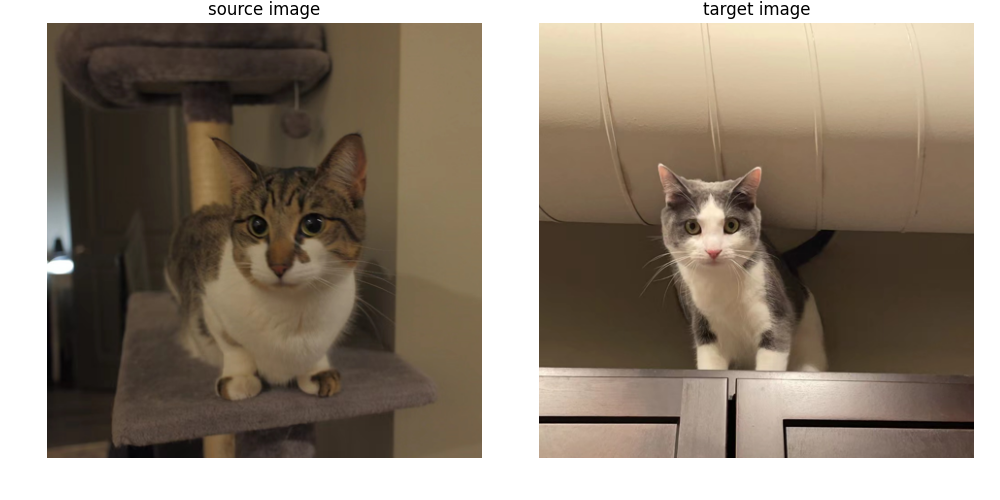

In [ ]:
'''
left is source image, right is target image.
you can click on the source image, and DIFT will find the corresponding
point on the right image, mark it with red point and also plot the per-pixel
cosine distance as heatmap.
'''
demo.plot_img_pairs(fig_size=5)